### Import Modules

In [14]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect
from langdetect import DetectorFactory

### Import Data and Add Category Names
The category names are stored in a separate JSON file. The category IDs in the dataframe are numeric. In order to lookup the keys and and map the values, I created a new column with the string version of the ID, then dropped it after the mapping was completed.

**Note:** The dataset file used for this project exceeds the file limit size for GitHub. The dataset is available from [Kaggle](https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset/versions/835).

In [9]:
df = pd.read_csv("US_youtube_trending_data.csv")

category_ids = dict()
with open('US_category_id.json', 'r') as f:
    category_data = json.load(f)

for category in category_data['items']:
    category_ids[category['id']] = category['snippet']['title']
    
df['category_id_str'] = df['categoryId'].astype('string')
df['category_name'] = df['category_id_str'].map(category_ids)
df.drop('category_id_str', axis=1, inplace=True)

### DOW and Days to Trend
Fortunately, parsing the dates and times in the data was straightforward. After that, it was simple to calculate the number of days it took for each video to trend on YouTube, and get the day name the video was published.

In [10]:
df[['publishedAt', 'trending_date']] = df[['publishedAt', 'trending_date']].apply(pd.to_datetime)
df['days_to_trend'] = (df['trending_date'] - df['publishedAt']).dt.days

df['published_dow'] = df['publishedAt'].dt.day_name()

### Cleanup
Just reordering of the columns, dropping the link to the video thumbnail, then converting all the column names to camel case for consistency.

In [11]:
df = df.reindex(columns=['video_id', 'title', 'channelId', 'channelTitle', 'categoryId', 'category_name',
        'publishedAt', 'published_dow', 'trending_date', 'days_to_trend','comment_count', 'view_count',
        'likes', 'dislikes', 'comments_disabled', 'thumbnail_link', 'ratings_disabled', 'description', 'tags'])
df.drop('thumbnail_link', axis=1, inplace=True)
df.rename(columns = {'channelId':'channel_id', 'channelTitle':'channel_title', 'publishedAt': 'published_at',
                     'categoryId': 'category_id'}, inplace = True)

## Visualization

### Top 25 Channels
Bar graph of the 25 channels with the most trending videos.

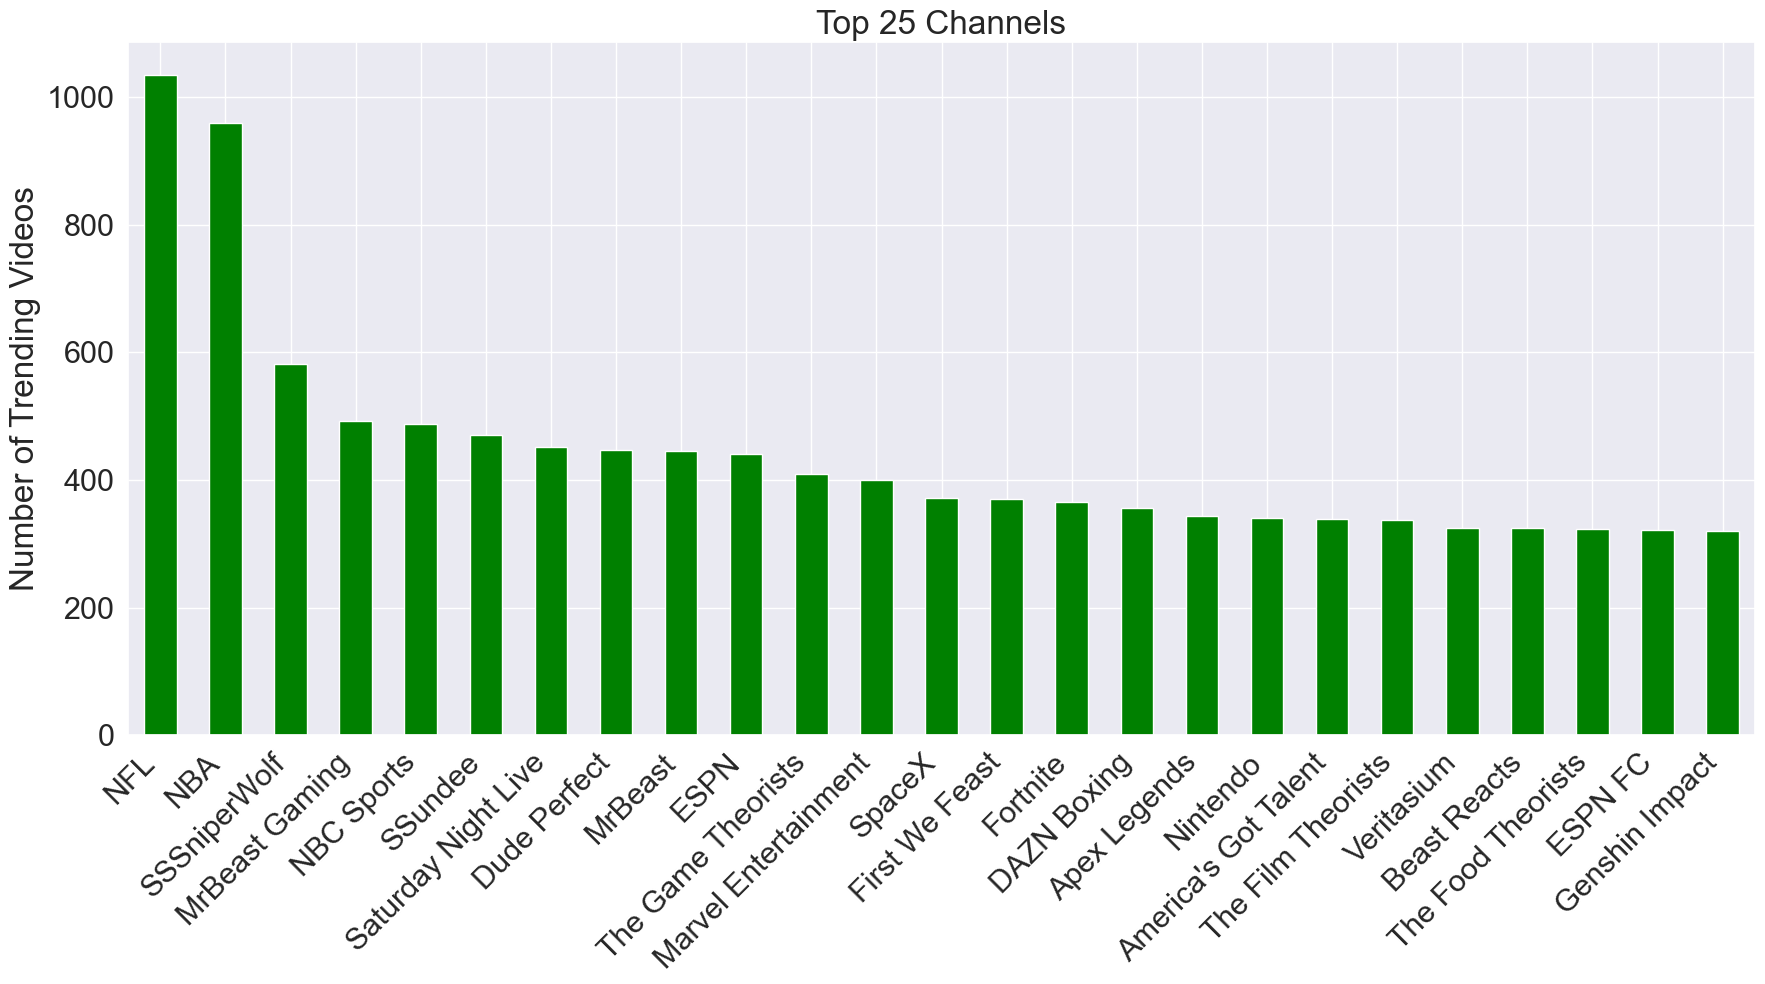

In [5]:
sns.set(rc={'figure.figsize':(21, 9)})
sns.set_style('ticks')
sns.set(font_scale=2)
top_25_channels = df.groupby(['channel_title']).size().sort_values(ascending=False).head(25)

chart = top_25_channels.plot(kind='bar', color='green')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(
    title='Top 25 Channels',
    xlabel='',
    ylabel='Number of Trending Videos'
)

plt.show()


### Top Trending by Category
Bar graph of the number of trending videos by category, in descending order.

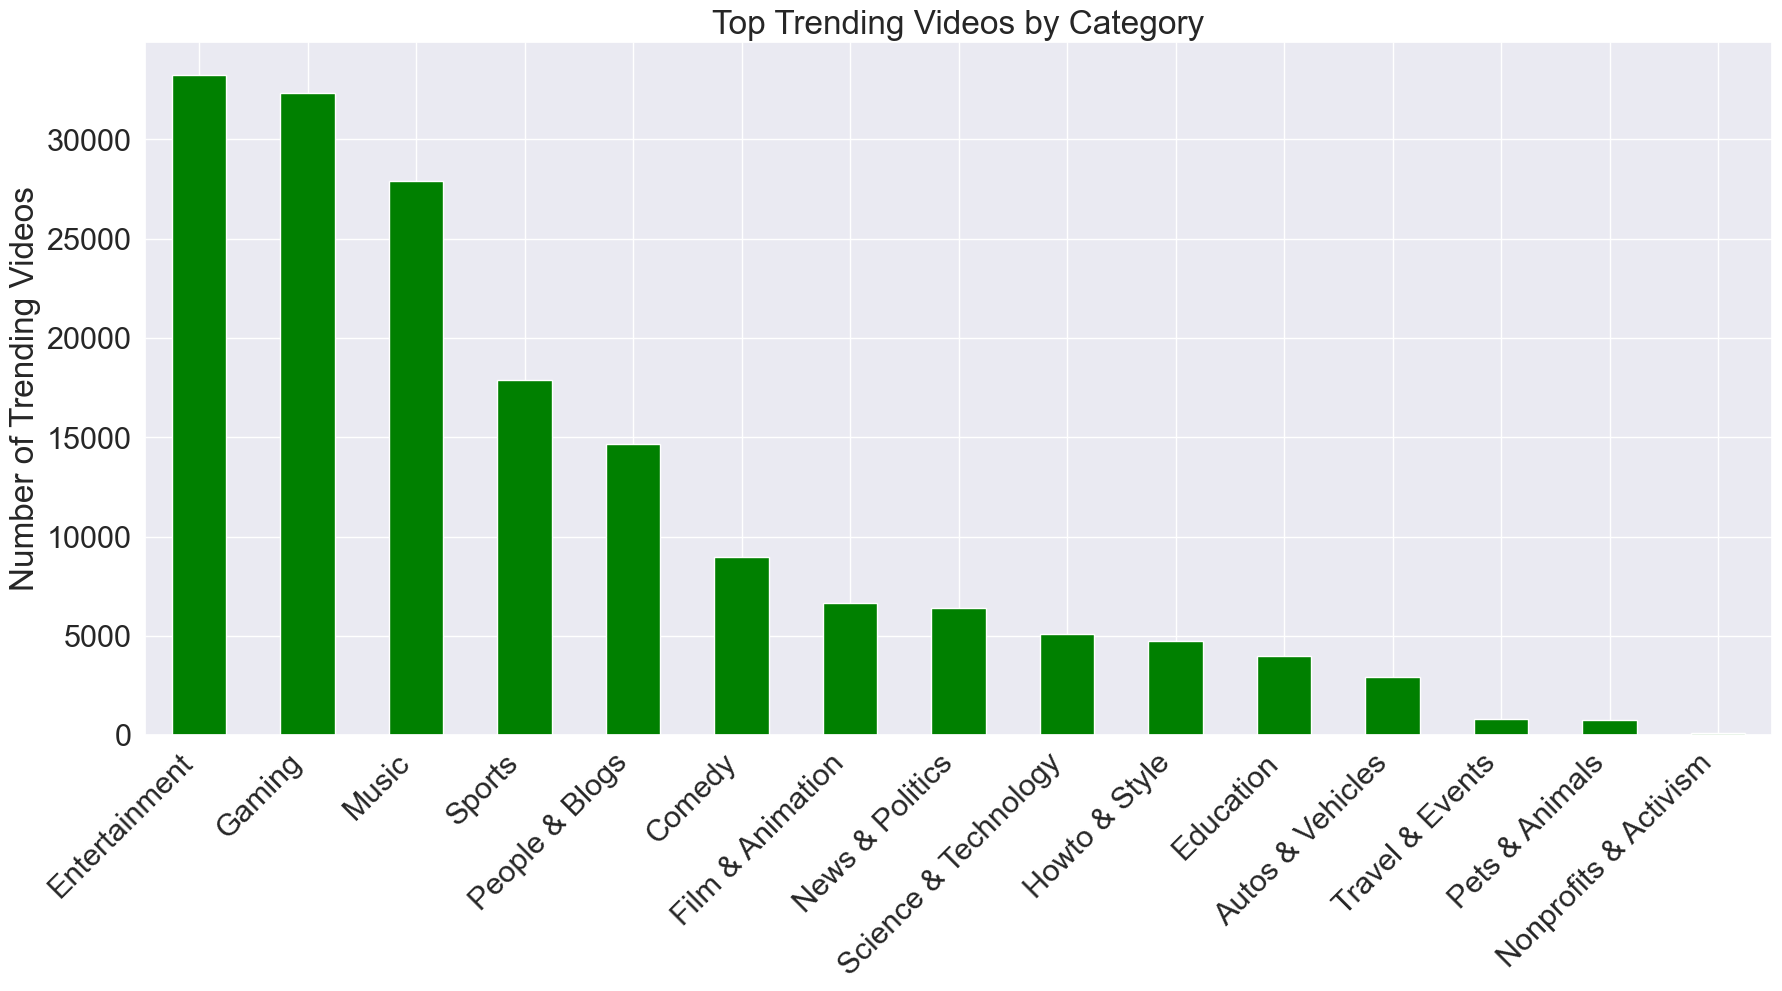

In [6]:
category_counts = df.groupby(['category_name']).size().sort_values(ascending=False)

sns.set(rc={'figure.figsize':(21, 9)})
sns.set_style('ticks')
sns.set(font_scale=2)
chart = category_counts.plot(kind='bar', color='green')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(
    title='Top Trending Videos by Category',
    xlabel='',
    ylabel='Number of Trending Videos'
)

plt.show()

### Day of the Week Published
I wondered if the day of the week the video was published might have an impact on whether or not it trended. However, it is a pretty even distribution.

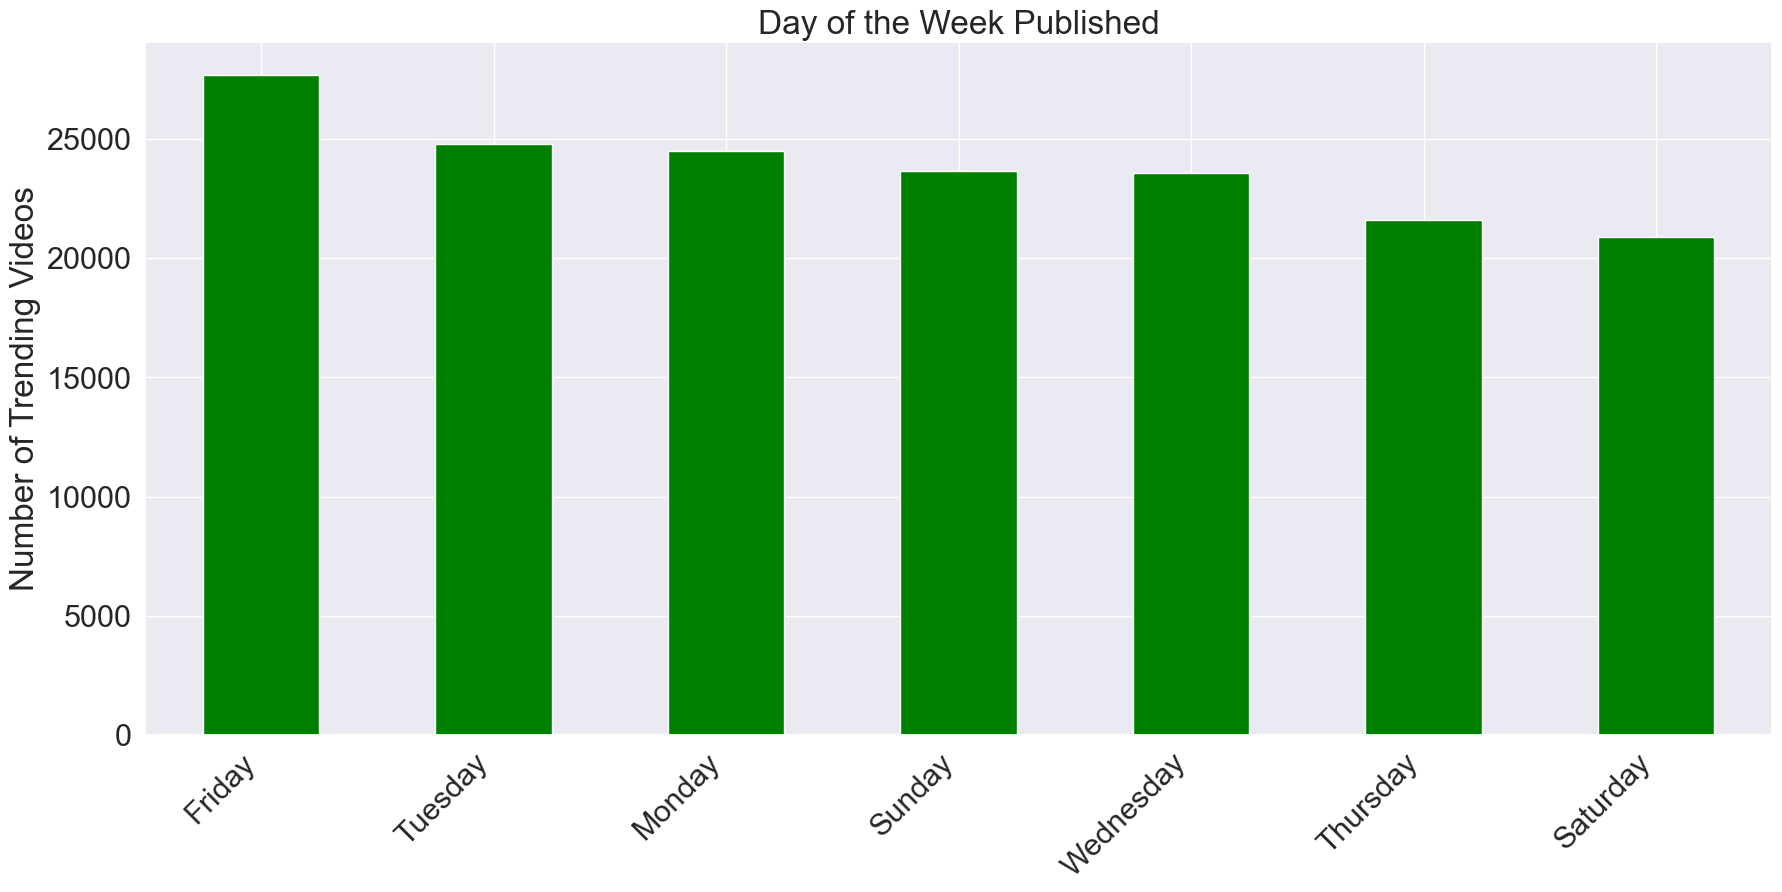

In [7]:
day_published = df.groupby(['published_dow']).size().sort_values(ascending=False)

sns.set(rc={'figure.figsize':(21, 9)})
sns.set_style('ticks')
sns.set(font_scale=2)
chart = day_published.plot(kind='bar', color='green')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(
    title='Day of the Week Published',
    xlabel='',
    ylabel='Number of Trending Videos'
)

plt.show()

### Days to Trend
The number of days from when the video was published, to when it trended. Most trend within a week, though there are some notable outliers.

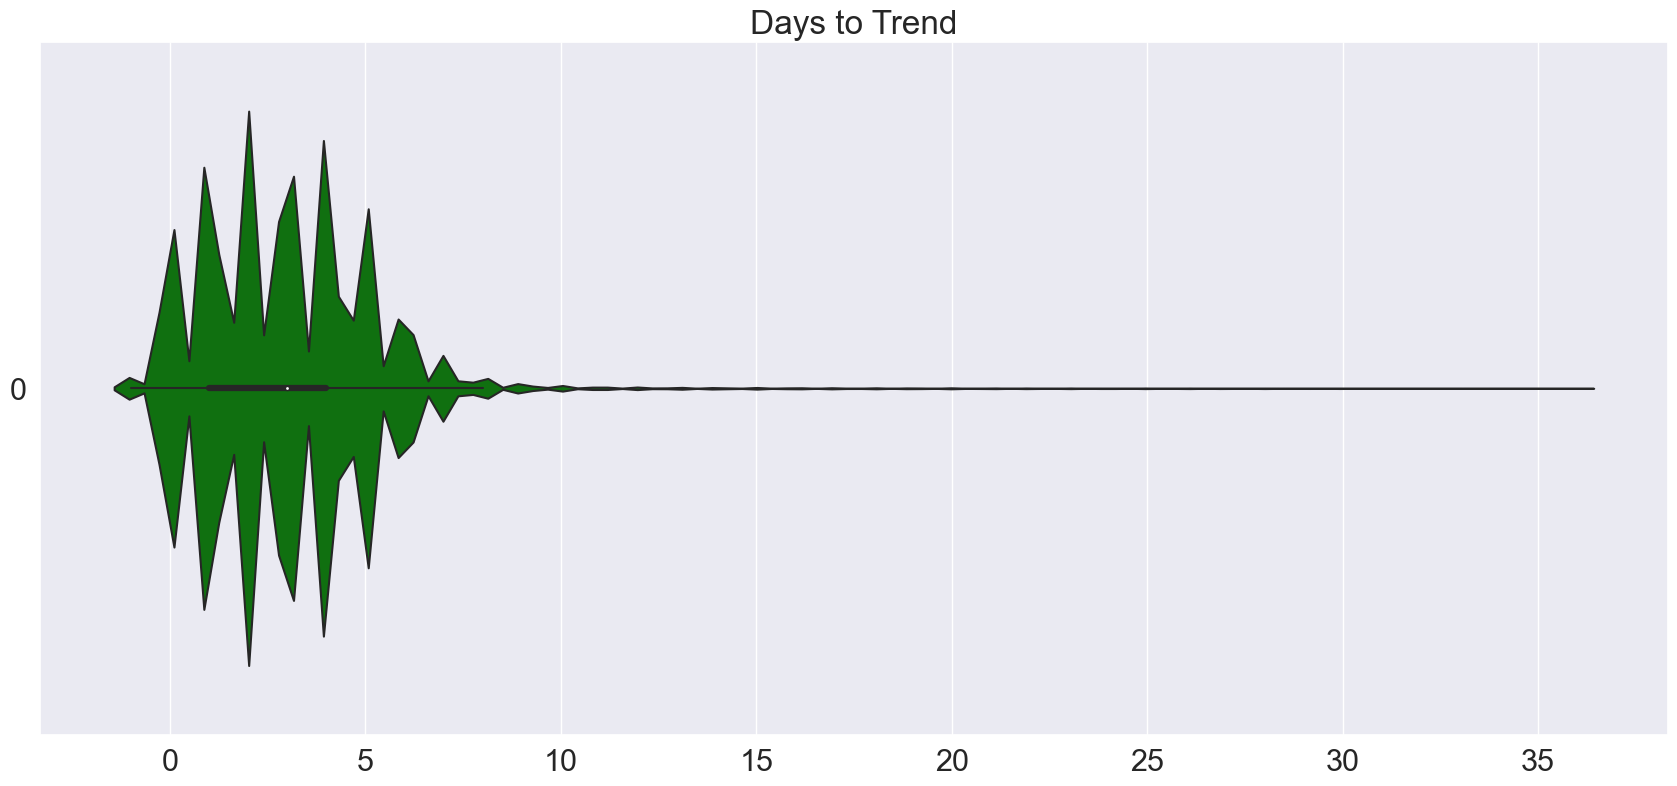

In [8]:
sns.set(rc={'figure.figsize':(21, 9)})
sns.set(style='whitegrid')
sns.set(font_scale=2)
vp = sns.violinplot(data=df['days_to_trend'], color='green', orient='h')
vp.set(title='Days to Trend',
      xlabel='')

plt.show()

### Correlation Chart
Most of the properties in the dataset are for cataloging purposes. However, I decided to drop some of those, create some dummy variables for the categorical variables, then create a correlation chart.

There is some correlation between comment_count, likes, and dislikes and the view_count, but this is expected.

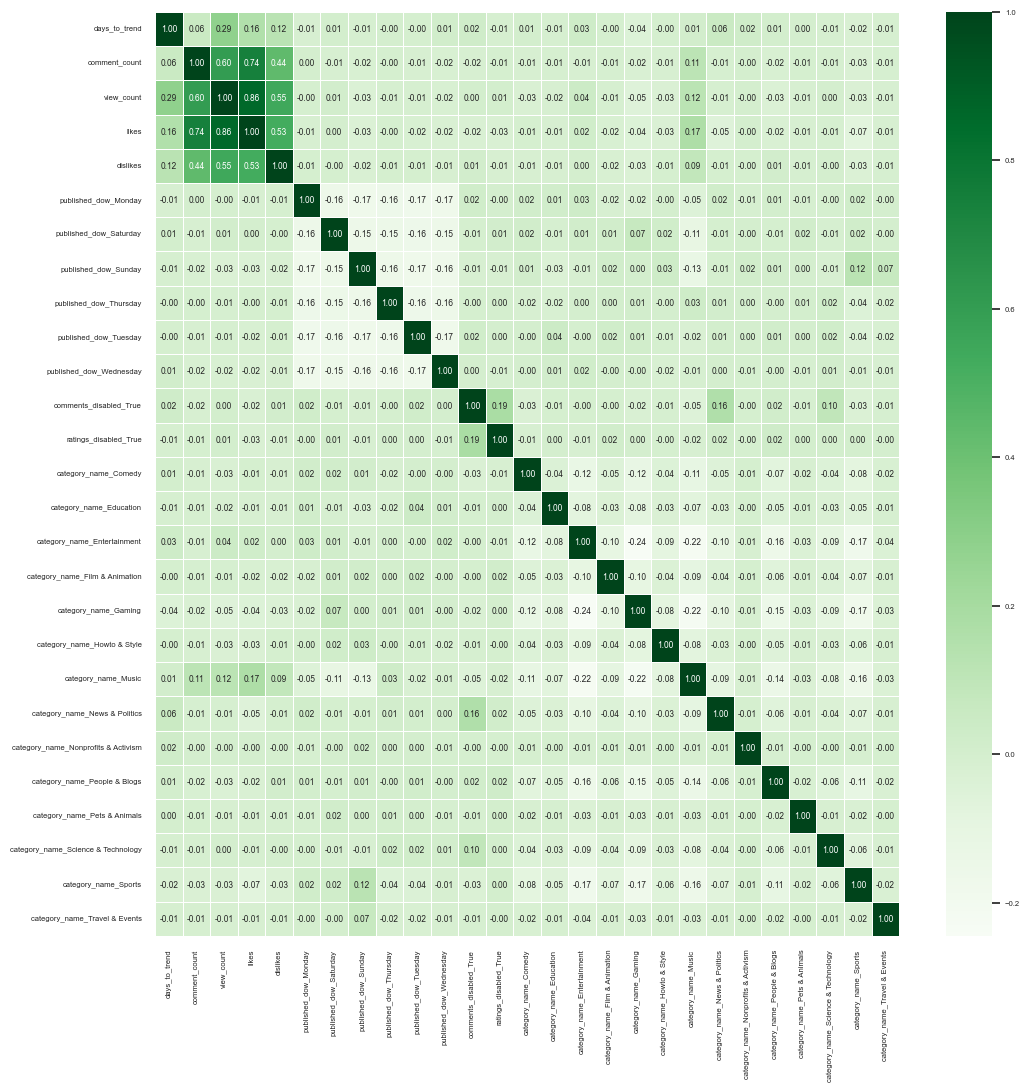

In [9]:
yt = df.copy()
columns_to_drop = ['video_id', 'title', 'channel_id', 'channel_title', 'category_id',
                   'published_at', 'trending_date', 'description', 'tags']
yt.drop(columns_to_drop, axis=1, inplace=True)
categoricals = ['published_dow', 'comments_disabled', 'ratings_disabled', 'category_name']
yt = pd.get_dummies(yt, columns = categoricals, drop_first = True)

yt_corr = yt.corr()
sns.set(font_scale=0.5)
plt.figure(figsize = (12, 12))
hmap = sns.heatmap(
    yt_corr,
    annot = True,
    fmt = '.2f',
    cmap = 'Greens',
    linewidth = 0.5
)

plt.show()

del yt

### Video Description Sentiment Analysis
I ran sentiment analysis on the video descriptions. They all were classified as neutral.

In [12]:
def get_sentiment(text) -> str:
    analyzer = SentimentIntensityAnalyzer()
    sentiment_dict = analyzer.polarity_scores(text)
    if sentiment_dict['compound'] >= 0.05:
        return 'positive'
    elif sentiment_dict['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'
    
df = df.assign(desc_sentiment = lambda x: get_sentiment(x))

print('Count - unique description sentiments:\t{count}'.format(count=len(pd.unique(df['desc_sentiment']))))

df.drop('desc_sentiment', axis=1, inplace=True)

Count - unique description sentiments:	1


## Comment Scraping and Sentiment Analysis
Since there are so many records in this dataset, I was unable to scrape comments from them all due to time and resourece constraints. I decided to create a new dataframe for the most recent 120 videos.

In [13]:
df2 = df.copy()
df2.sort_values(by = 'trending_date', ascending=False, inplace=True)
df2.reset_index(inplace=True)
df2.drop(df2[df2['comments_disabled'] == True].index, inplace = True)
n = len(df2.axes[0]) - 120
df2.drop(df2.tail(n).index, inplace=True)

### Opening the Pages
Since YouTube pages are dynamic, a typical scraping tool like Beautiful Soup cannot be used to scrape the comments. Instead I had to use Selenium to open each page, scroll down to get the comments, then scrape them. The function will record all the collected comments if the given sample_size is -1, with a default to selct a random sample, without replacement, of 500 comments.The comments are then saved to a JSON file.

Future Improvements:
- [ ] Update the main dataframe when comments have been disabled after initial collection.

**Notes:**
- This step can take a while to complete. Comments from a previous run are included if you want to skip this step.
- If you are running this step, if you do not have chromedriver in your path, you will need to pass in the path to the executable when creating the webdriver. You can of course use Firefox, Edge, or another browser as well.
- In order to prevent duplication, the comments are stored in a set. The set is converted to a list at the end, however since sets are unordered, the comments will not be stored in the order collected.

In [19]:
def write_comments_to_json(video_id, sample_size=500):
    result = {'video_id': video_id}
    
    comments_disabled = False
    
    driver = webdriver.Chrome()
    driver.get('https://www.youtube.com/watch?v={id}'.format(id=video_id))
    
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'description')))

    html = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'html')))
    html.send_keys(Keys.PAGE_DOWN)
    html.send_keys(Keys.PAGE_DOWN)

    comments = set()
    try:
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="count"]/yt-formatted-string/span[1]')))
    except:
        comments_disabled = True
    
    if comments_disabled:
        result['comments'] = []
        result['comments_disabled'] = True
        with open("comments/{filename}_comments.json".format(filename=video_id), 'w') as f:
            json.dump(result, f, indent=4)
        driver.close()
    else:
        last_height = driver.execute_script('return document.documentElement.scrollHeight')
        while True:
            driver.execute_script('window.scrollTo(0, document.documentElement.scrollHeight);')
            time.sleep(3)
        
            new_height = driver.execute_script('return document.documentElement.scrollHeight')
        
            comment_elems = driver.find_elements(By.XPATH, '//*[@id="content-text"]')
            new_comments = [elem.text for elem in comment_elems]
            comments.update(new_comments)
        
            if new_height == last_height:
                break
            else:
                last_height = new_height
        
        if len(comments) <= sample_size or sample_size == -1:
            result['comments'] = list(comments)
        else:
            result['comments'] = random.sample(list(comments), sample_size)
            
        result['comments_disabled'] = comments_disabled
        with open("comments/{filename}_comments.json".format(filename=video_id), 'w') as f:
            json.dump(result, f, indent=4)
    
        driver.close()

video_ids = df2["video_id"].to_list()

for video_id in video_ids:
    write_comments_to_json(video_id)



### Sentiment Analysis
I decided to use [Vader](https://github.com/Holek/vader_sentiment) for sentiment analysis, since it is designed for social media and it very easy to use.

Here I open the previously scraped comments, then run language detection. I tally the non-English and non-detectable comments. Sentiment analysis is performed on the English comments, keeping a running total of each type. The results are then placed into a new dataframe. The new dataframe is joined with the previous one, using a left join. The final data is then written to a CSV file.

Future Improvements:
- [ ] Have the option to exclude, or attempt translation for non-English language comments.

In [20]:
DetectorFactory.seed = 0
results = list()
analyzer = SentimentIntensityAnalyzer()
directory = 'comments'
 
for filename in os.listdir(directory):
    fp = os.path.join(directory, filename)
    if os.path.isfile(fp) and fp.endswith('_comments.json'):
        with open(fp, 'r') as f:
            data = json.load(f)
            result = {'video_id': data['video_id'],
                      'positive': 0,
                      'negative': 0,
                      'neutral': 0,
                      'non_en': 0,
                      'langd_fail': 0}
            for comment in data["comments"]:
                language = None
                try:
                    language = detect(comment)
                except:
                    result['langd_fail'] += 1
                
                if language and language != 'en':
                    result['non_en'] += 1
                    
                if language and language == 'en':   
                    sentiment_dict = analyzer.polarity_scores(comment)
                    if sentiment_dict['compound'] >= 0.05:
                        result['positive'] += 1
                    elif sentiment_dict['compound'] <= -0.05:
                        result['negative'] += 1
                    else:
                        result['neutral'] += 1
            results.append(result)

df3 = pd.DataFrame.from_dict(results)

df4 = pd.merge(df3, df2,  on='video_id', how='left')
df4 = df4.drop(columns=['index'])
df4.to_csv('output/ytsentiment.csv', index=False)

### Sentiment Counts
Violin plot of the collected sentiments. 

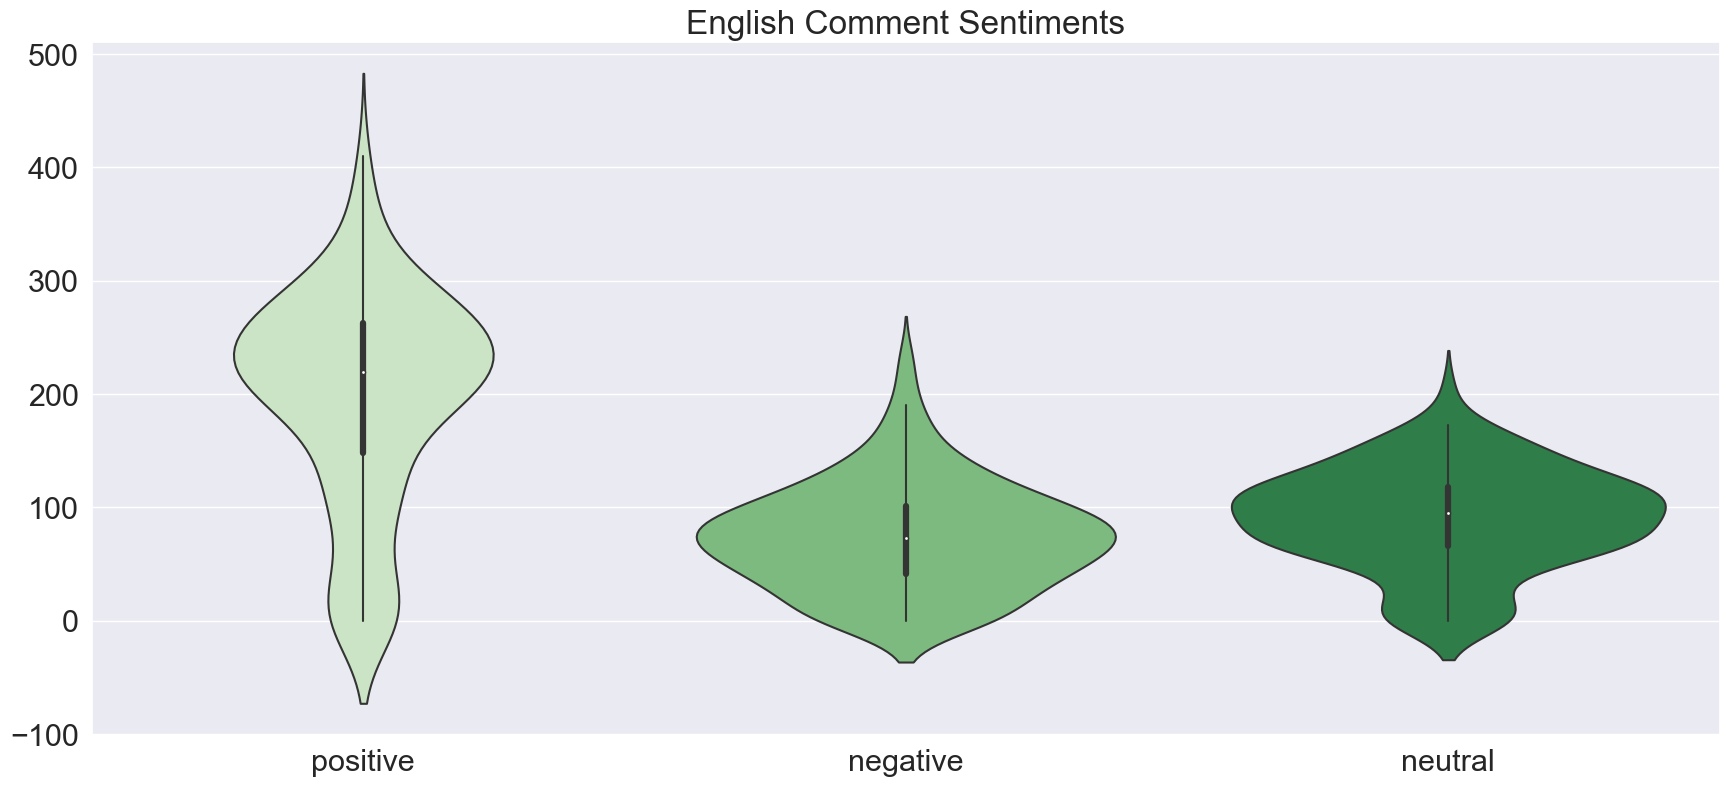

In [25]:
temp = df4[['positive','negative', 'neutral']].copy()

temp_melted = pd.melt(temp)

sns.set(rc={'figure.figsize':(21, 9)})
sns.set_style('ticks')
sns.set(font_scale=2)

vp = sns.violinplot(x='variable', y='value', data=temp_melted, palette='Greens')

vp.set(title='English Comment Sentiments',
      xlabel='', ylabel='')

plt.show()

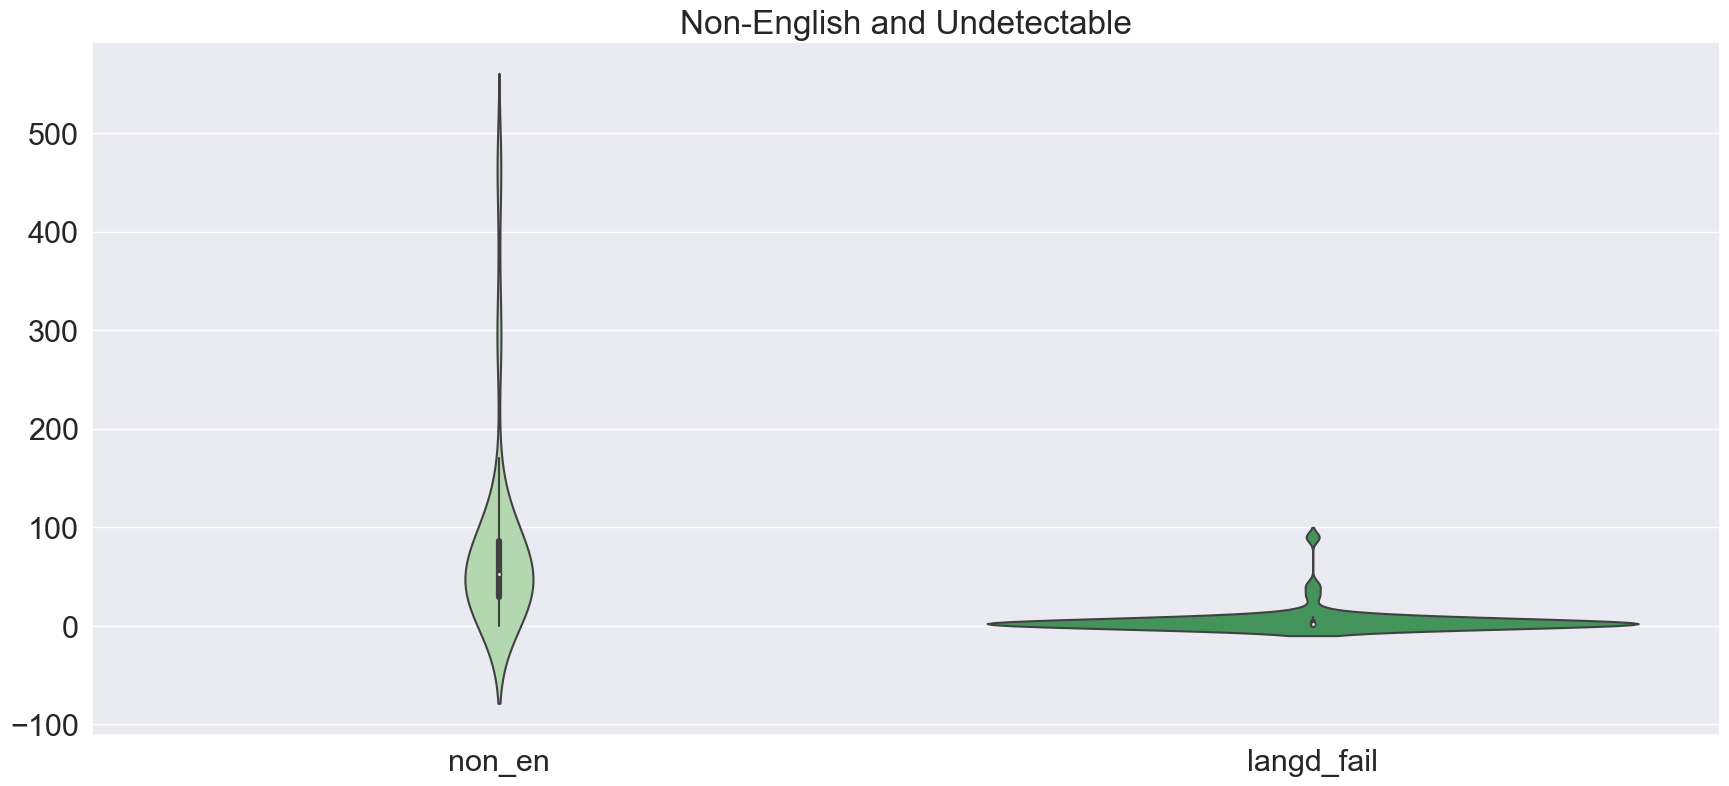

In [27]:
temp = df4[['non_en','langd_fail']].copy()

temp_melted = pd.melt(temp)

sns.set(rc={'figure.figsize':(21, 9)})
sns.set_style('ticks')
sns.set(font_scale=2)

vp = sns.violinplot(x='variable', y='value', data=temp_melted, palette='Greens')

vp.set(title='Non-English and Undetectable',
      xlabel='', ylabel='')

plt.show()